In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from dataset import BrightfieldMicroscopyDataset

from scipy.fft import fft2, ifft2, fftshift, ifftshift

from torch.utils.data import DataLoader

from tqdm import tqdm
import random

In [19]:
train_set = BrightfieldMicroscopyDataset()

In [20]:
image, label = train_set[100]

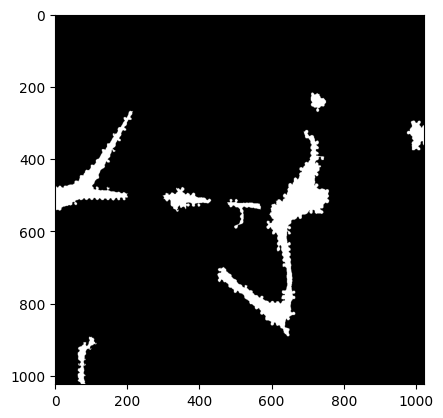

In [21]:
plt.imshow(label, cmap='gray')

In [22]:
def remove_repeating_pattern(input_image, threshold=0.1, iterations=1):
    """
    Removes repeating patterns from an image using FFT.
    
    Parameters:
    - image: 2D numpy array, the input image.
    - threshold: float, threshold for identifying peaks in the frequency domain.
    - iterations: int, number of iterations to refine the pattern removal.

    Returns:
    - cleaned_image: 2D numpy array, the image with the pattern removed.
    """
    image = input_image.copy()
    for _ in range(iterations):
        # Step 1: FFT to frequency domain
        f = fft2(image)
        fshift = fftshift(f)
        magnitude = np.abs(fshift)

        # Step 2: Identify pattern frequencies
        mask = magnitude > (threshold * np.max(magnitude))
        pattern_fshift = fshift * mask

        # Step 3: Reconstruct pattern using inverse FFT
        pattern = np.real(ifft2(ifftshift(pattern_fshift)))

        # Step 4: Subtract pattern from original image
        image = image - pattern

    return image

In [39]:
def calculate_segmentation_metrics(predicted_mask, label_mask):
    """
    Calculate segmentation performance metrics.
    
    Args:
        predicted_mask (numpy.ndarray): Predicted binary segmentation mask
        label_mask (numpy.ndarray): Ground truth binary segmentation mask
    
    Returns:
        dict: Segmentation performance metrics
    """
    # Ensure masks are binary (0 or 1)
    predicted_mask = (predicted_mask > 0).astype(np.uint8)
    label_mask = (label_mask > 0).astype(np.uint8)
    
    # Pixel Accuracy: Proportion of correctly classified pixels
    pixel_accuracy = np.sum(predicted_mask == label_mask) / label_mask.size
    
    # Intersection over Union (IoU)
    intersection = np.logical_and(predicted_mask, label_mask)
    union = np.logical_or(predicted_mask, label_mask)
    iou = np.sum(intersection) / np.sum(union)
    
    # Dice Coefficient (F1 Score)
    dice_coefficient = 2 * np.sum(intersection) / (np.sum(predicted_mask) + np.sum(label_mask))
    
    # Precision: Proportion of predicted positives that are actually positive
    true_positives = np.sum(np.logical_and(predicted_mask, label_mask))
    predicted_positives = np.sum(predicted_mask)
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    
    # Recall: Proportion of actual positives that are correctly predicted
    actual_positives = np.sum(label_mask)
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    
    return {
        'pixel_accuracy': pixel_accuracy,
        'iou': iou,
        'dice_coefficient': dice_coefficient,
        'precision': precision,
        'recall': recall
    }

In [52]:
def preprocess_channel(channel, threshold=0.01, iterations=2):
    """
    Preprocess a single channel image for segmentation.
    
    Args:
        channel (np.ndarray): Single channel image
        threshold (float, optional): Threshold for removing repeating patterns. Defaults to 0.01.
        iterations (int, optional): Number of iterations for pattern removal. Defaults to 2.
    
    Returns:
        np.ndarray: Preprocessed channel image
    """
    # Remove repeating pattern
    cleaned_channel = remove_repeating_pattern(channel, threshold=threshold, iterations=iterations)
    
    # Normalize to 0-255 range
    tensor_min = cleaned_channel.min()
    tensor_max = cleaned_channel.max()
    normalized_channel = (cleaned_channel - tensor_min) / (tensor_max - tensor_min) * 255
    normalized_channel = normalized_channel.astype(np.uint8)
    
    # Edge detection
    edged = cv2.Canny(normalized_channel, 70, 80)
    
    # Dilation
    dilation_kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edged, dilation_kernel, iterations=1)
    
    return dilated

def post_process_segmentation(processed_image):
    """
    Apply post-processing steps to the segmentation result.
    
    Args:
        processed_image (np.ndarray): Processed image to refine
    
    Returns:
        np.ndarray: Refined segmentation result
    """
    # Convert to absolute scale
    img = cv2.convertScaleAbs(processed_image)
    
    # Gaussian blur and Otsu's thresholding
    blur = cv2.GaussianBlur(img, (11, 11), 5)
    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Morphological opening
    kernel = np.ones((10, 10), np.uint8)
    opening = cv2.morphologyEx(th3.copy(), cv2.MORPH_OPEN, kernel)
    
    # Crop and remove border regions
    return crop_image_borders(opening)

def crop_image_borders(image, crop_width=15, corner_width=100, corner_height=100):
    """
    Remove border and corner regions from the image.
    
    Args:
        image (np.ndarray): Input image
        crop_width (int, optional): Width of border to remove. Defaults to 15.
        corner_width (int, optional): Width of corner area to remove. Defaults to 100.
        corner_height (int, optional): Height of corner area to remove. Defaults to 100.
    
    Returns:
        np.ndarray: Image with borders and corners removed
    """
    cropped = image.copy()
    
    # Remove borders
    cropped[:crop_width, :] = 0
    cropped[-crop_width:, :] = 0
    cropped[:, :crop_width] = 0
    cropped[:, -crop_width:] = 0
    
    # Remove corner regions
    cropped[:corner_height, :corner_width] = 0
    cropped[:corner_height, -corner_width:] = 0
    cropped[-corner_height:, :corner_width] = 0
    cropped[-corner_height:, -corner_width:] = 0
    
    return cropped

def fft_segmentation(image, label, channels_to_calculate=None):
    """
    Perform FFT-based segmentation on an image.
    
    Args:
        image (torch.Tensor): Input image tensor
        label (torch.Tensor): Ground truth label
        channels_to_calculate (int, optional): Number of channels to process. 
                                               Defaults to all channels.
    
    Returns:
        tuple: Processed image, original label, and segmentation metrics
    """
    # Convert to numpy and handle channel selection
    image_np = image.numpy()
    channels = image_np.shape[0]
    
    if channels_to_calculate is None:
        channels_to_calculate = channels
    
    # Process channels
    processed_channels = [
        preprocess_channel(image_np[i]) 
        for i in range(channels_to_calculate)
    ]
    
    # Average processed channels
    summed_image = np.mean(processed_channels, axis=0)
    
    # Post-process the averaged image
    processed_image = post_process_segmentation(summed_image)
    
    # Calculate metrics
    metrics = calculate_segmentation_metrics(processed_image, label.numpy())
    
    return processed_image, label, metrics

In [53]:
image, label = train_set[100]

predicted, label, metrics = fft_segmentation(image, label)

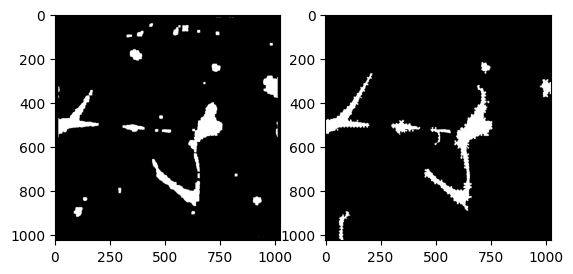

In [54]:
plt.subplot(1,2,1)
plt.imshow(predicted, 'gray')
plt.subplot(1,2,2)
plt.imshow(label, 'gray')

In [55]:
print("Segmentation Metrics:")
for metric, value in metrics.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Segmentation Metrics:
Pixel Accuracy: 0.9677
Iou: 0.5343
Dice Coefficient: 0.6965
Precision: 0.7004
Recall: 0.6927


In [66]:
train_dataloader = DataLoader(train_set, batch_size=1, shuffle=False)

In [64]:
def perform_segmentation_evaluation(dataloader, print_interval=20):
    all_metrics = {
        'pixel_accuracy': [],
        'iou': [],
        'dice_coefficient': [],
        'precision': [],
        'recall': []
    }

    # Iterate through the dataloader
    for idx, (image, label) in enumerate(tqdm(dataloader, desc="Segmentation Evaluation"), 1):
        image = image[0]
        label = label[0]
        
        # Perform segmentation based on the chosen method
        predicted_mask, _, _ = fft_segmentation(image, label)
        
        # Calculate metrics for this batch
        batch_metrics = calculate_segmentation_metrics(predicted_mask, label.numpy())
        
        # Store metrics
        for metric_name, metric_value in batch_metrics.items():
            all_metrics[metric_name].append(metric_value)
        
        # Print intermediate metrics at specified interval
        if idx % print_interval == 0:
            print(f"\nIntermediate Metrics at Image {idx}:")
            current_aggregated_metrics = {
                metric_name: np.mean(metric_values)
                for metric_name, metric_values in all_metrics.items()
            }
            
            for metric_name, metric_value in current_aggregated_metrics.items():
                print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.4f}")
    
    # Calculate final average metrics
    aggregated_metrics = {
        metric_name: np.mean(metric_values)
        for metric_name, metric_values in all_metrics.items()
    }
    
    # Calculate metric variance for additional insight
    metric_variance = {
        metric_name: np.var(metric_values)
        for metric_name, metric_values in all_metrics.items()
    }
    
    # Print final detailed results
    print("\nFinal Segmentation Metrics Summary:")
    for metric_name, metric_value in aggregated_metrics.items():
        print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.4f}")
    
    print("\nFinal Metric Variance:")
    for metric_name, variance in metric_variance.items():
        print(f"{metric_name.replace('_', ' ').title()} Variance: {variance:.6f}")
    
    return {
        'mean_metrics': aggregated_metrics,
        'metric_variance': metric_variance,
        'per_batch_metrics': all_metrics
    }

In [67]:
results = perform_segmentation_evaluation(train_dataloader, print_interval=20)

Segmentation Evaluation:   2%|▏         | 20/1000 [00:42<33:42,  2.06s/it]


Intermediate Metrics at Image 20:
Pixel Accuracy: 0.9345
Iou: 0.4436
Dice Coefficient: 0.6054
Precision: 0.6379
Recall: 0.5961


Segmentation Evaluation:   4%|▍         | 40/1000 [01:24<33:57,  2.12s/it]


Intermediate Metrics at Image 40:
Pixel Accuracy: 0.9294
Iou: 0.4319
Dice Coefficient: 0.5898
Precision: 0.6160
Recall: 0.6043


Segmentation Evaluation:   6%|▌         | 60/1000 [02:04<27:54,  1.78s/it]


Intermediate Metrics at Image 60:
Pixel Accuracy: 0.9136
Iou: 0.4277
Dice Coefficient: 0.5869
Precision: 0.6426
Recall: 0.5801


Segmentation Evaluation:   8%|▊         | 79/1000 [02:42<31:37,  2.06s/it]


RuntimeError: Missing images or labels for index 79. Images: [[[124 128 129 ... 153 145 133]
  [128 125 120 ... 159 148 137]
  [136 133 128 ... 157 146 136]
  ...
  [107  91  93 ... 161 141 123]
  [124 104  89 ... 174 160 144]
  [143 125 108 ... 183 172 160]]

 [[119 125 125 ... 156 145 135]
  [123 120 117 ... 161 151 143]
  [136 133 130 ... 158 151 142]
  ...
  [100  81  81 ... 159 139 121]
  [121  99  81 ... 175 163 147]
  [143 124 107 ... 183 177 166]]

 [[105 111 109 ... 157 151 141]
  [114 110 110 ... 168 163 155]
  [138 134 137 ... 167 160 152]
  ...
  [ 93  69  63 ... 157 137 116]
  [120  92  70 ... 178 166 154]
  [144 124 106 ... 184 182 177]]

 ...

 [[ 65  51  51 ... 183 179 172]
  [123 109 108 ... 181 182 180]
  [160 159 163 ... 183 187 182]
  ...
  [104  66  56 ... 177 167 144]
  [140 104  77 ... 178 179 175]
  [159 144 126 ... 190 195 194]]

 [[ 59  49  49 ... 178 173 170]
  [114 101  99 ... 182 185 184]
  [159 153 158 ... 201 204 204]
  ...
  [ 80  57  56 ... 183 163 139]
  [111  82  63 ... 208 201 194]
  [151 125 108 ... 217 224 221]]

 [[ 53  48  49 ... 173 169 168]
  [101  89  90 ... 195 200 198]
  [153 146 147 ... 219 228 225]
  ...
  [ 63  54  60 ... 184 160 132]
  [ 92  69  62 ... 220 213 196]
  [137 114  97 ... 237 234 230]]], Label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

In [62]:
def visualize_segmentation(dataset, segmentation_function, n_samples=5):
    # Draw n random indices from the dataset
    indices = random.sample(range(len(dataset)), n_samples)

    for i, idx in enumerate(indices):
        # Get the image and label pair
        image, label = dataset[idx]

        # Perform segmentation
        predicted, label, metrics = segmentation_function(image, label)

        # Plot the original image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image[0], cmap='gray')
        plt.axis('off')

        # Plot the predicted mask
        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        plt.imshow(predicted, cmap='gray')
        plt.axis('off')

        # Plot the groundtruth mask
        plt.subplot(1, 3, 3)
        plt.title("Ground Truth Mask")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.suptitle(f"Sample {i + 1}")
        plt.show()

        # Print segmentation metrics
        print("Segmentation Metrics for Sample", i + 1)
        for metric, value in metrics.items():
            print(f"  {metric.replace('_', ' ').title()}: {value:.4f}")
        print("-" * 30)

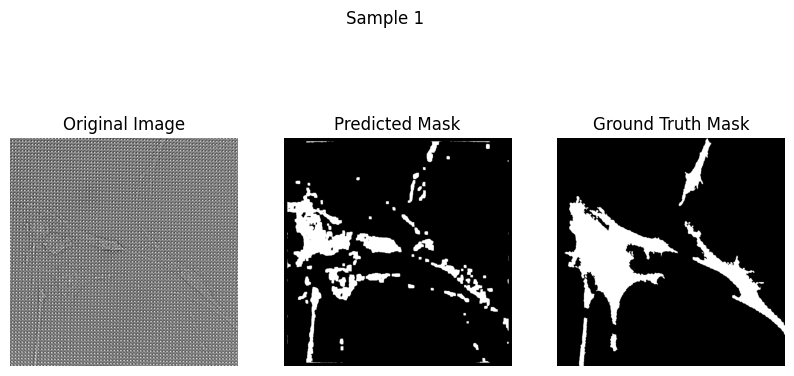

Segmentation Metrics for Sample 1
  Pixel Accuracy: 0.9133
  Iou: 0.4930
  Dice Coefficient: 0.6604
  Precision: 0.7914
  Recall: 0.5666
------------------------------


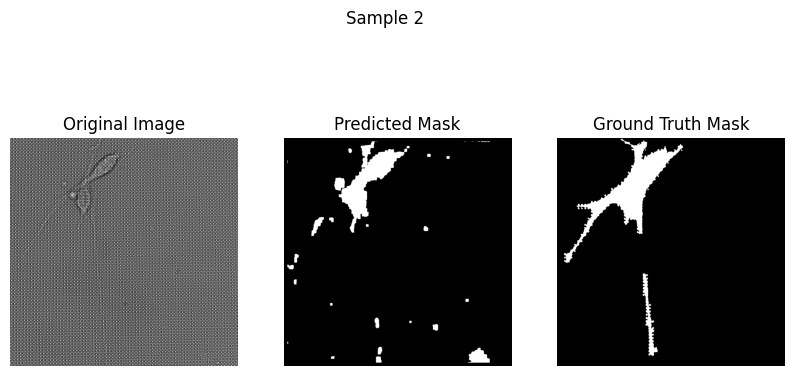

Segmentation Metrics for Sample 2
  Pixel Accuracy: 0.9620
  Iou: 0.4869
  Dice Coefficient: 0.6550
  Precision: 0.7509
  Recall: 0.5807
------------------------------


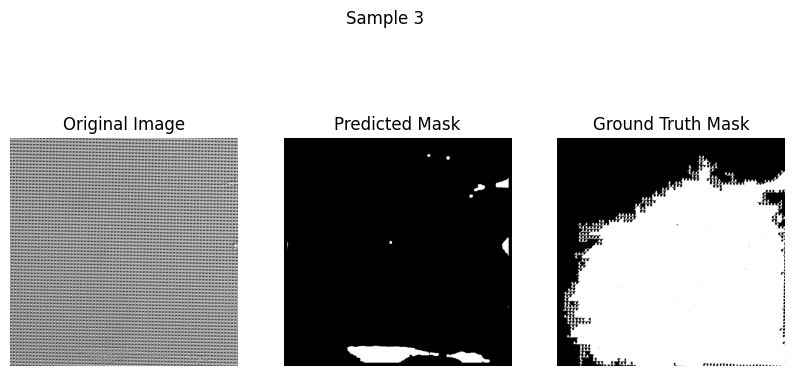

Segmentation Metrics for Sample 3
  Pixel Accuracy: 0.3655
  Iou: 0.0438
  Dice Coefficient: 0.0838
  Precision: 0.9863
  Recall: 0.0438
------------------------------


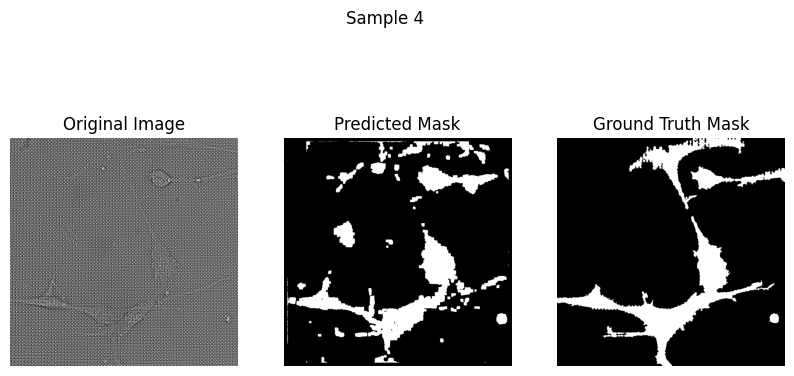

Segmentation Metrics for Sample 4
  Pixel Accuracy: 0.9165
  Iou: 0.5425
  Dice Coefficient: 0.7034
  Precision: 0.6871
  Recall: 0.7206
------------------------------


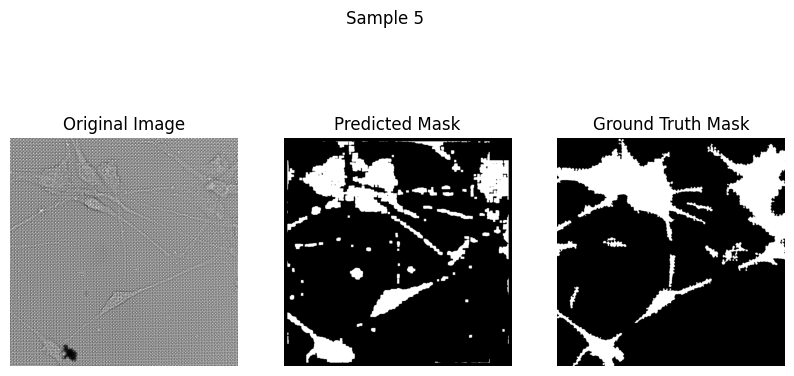

Segmentation Metrics for Sample 5
  Pixel Accuracy: 0.8803
  Iou: 0.5150
  Dice Coefficient: 0.6799
  Precision: 0.7539
  Recall: 0.6191
------------------------------


In [63]:
visualize_segmentation(train_set, fft_segmentation, n_samples=5)